# Um trem com imagem

Um jeito fácil de entender como CNN funciona é através do processo de classificação de imagens, em que as imagem são tratadas como matrizes tridimesionais e passam por algumas camadas de filtros (convolução) e redução (pooling) para então entrar em uma rede neural padrão.

[Exemplo em Classificação de Números](https://www.cs.ryerson.ca/~aharley/vis/conv/flat.html)

In [ ]:
# Baixando base de dados

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

--2020-08-19 15:30:24--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.71.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.71.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  40.8MB/s    in 3.5s    

2020-08-19 15:30:28 (40.8 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-08-19 15:30:30--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.71.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.71.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114801

In [ ]:
# Descompactando 

import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

# Pastas com as imagens para treinamento
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

# Pastas com as imagens para validação
validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') > 0.85):
            print("Está bom para mim, pode parar.")
            self.model.stop_training = True

In [ ]:
# Limpando sessão e setando semente

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [ ]:
model = tf.keras.models.Sequential()

In [ ]:
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)))
model.add(tf.keras.layers.MaxPooling2D(2, 2))

In [ ]:
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))

In [ ]:
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))

In [ ]:
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))

In [ ]:
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))

In [ ]:
model.add(tf.keras.layers.Flatten())

In [ ]:
model.add(tf.keras.layers.Dense(512, activation='relu'))

In [ ]:
model.add(tf.keras.layers.Dropout(rate=0.2))

In [ ]:
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1/255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # Aqui vai a pasta onde estão as imagens de treino
        target_size=(300, 300),  # Tamanho das fotos
        batch_size=128,
        class_mode='binary')

Found 1027 images belonging to 2 classes.


In [ ]:
validation_generator = validation_datagen.flow_from_directory(
        '/tmp/validation-horse-or-human/',
        target_size=(300, 300),
        batch_size=32,
        class_mode='binary')

Found 256 images belonging to 2 classes.


In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=9,  
      epochs=100,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8,
      callbacks=[Callback()])

Epoch 1/100
9/9 [==============================] - 24s 3s/step - loss: 0.6827 - accuracy: 0.5375 - val_loss: 0.6369 - val_accuracy: 0.7539
Epoch 2/100
9/9 [==============================] - 26s 3s/step - loss: 0.6526 - accuracy: 0.6641 - val_loss: 0.6062 - val_accuracy: 0.6406
Epoch 3/100
9/9 [==============================] - 25s 3s/step - loss: 0.6089 - accuracy: 0.6981 - val_loss: 0.5608 - val_accuracy: 0.7656
Epoch 4/100
9/9 [==============================] - 26s 3s/step - loss: 0.6076 - accuracy: 0.6611 - val_loss: 0.7183 - val_accuracy: 0.5352
Epoch 5/100
9/9 [==============================] - 27s 3s/step - loss: 0.5625 - accuracy: 0.7235 - val_loss: 0.5855 - val_accuracy: 0.6367
Epoch 6/100
9/9 [==============================] - 27s 3s/step - loss: 0.5430 - accuracy: 0.7322 - val_loss: 0.8205 - val_accuracy: 0.5430
Epoch 7/100
9/9 [==============================] - 26s 3s/step - loss: 0.5208 - accuracy: 0.7390 - val_loss: 0.5818 - val_accuracy: 0.5000
Epoch 8/100
9/9 [==========

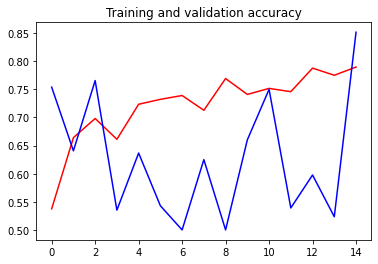

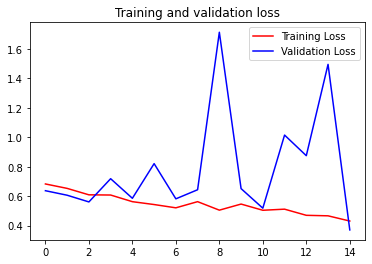

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()